# Schrodinger solver

We will develop a simple code to solve the Schrodinger equation for a 1D system, using numerical differentiation and integration, and optimisation techniques (specifically conjugate gradients).

We will assume that the wavefunction, $\psi(x)$, is represented by its value at grid points, and we will then vary these values to minimise the energy.  This way, we will be able to solve for *any* potential we define.

For simplicity, we'll consider a particle in a well (and then we'll add potentials into the well).  The end points will need to go to zero (assuming that the well is infinite).  The energy for any wavefunction is written as:

$$E = \frac{\int dx \psi^{\star}(x)\hat{H}\psi(x)}{\int dx \psi^{\star}(x)\psi(x)}$$

where we have $\hat{H} = -\frac{1}{2}\frac{d^2}{dx^2} + V(x)$ is the Hamitonian (I'm using atomic units, where $\hbar = m_e = 1/(4\pi\epsilon_0) = 1$ for simplicity).  Note that in this system, we can assume real wavefunctions.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize

In [3]:
# Physical parameters
L = 5
dx = 0.01
N = int(L/dx) + 1 
x_val = np.linspace(0,L,N)

# Space for wavefunction; we'll have to make an initial guess later
psi = np.zeros(N)

In [4]:
def second_derivative_second(psi,dx):
    """Evaluate second derivative of function on grid using finite differences
    Second-order formula, uses 3 points
    
    Inputs:
    psi  Function to be differentiated
    dx   Grid spacing
    
    Output:
    d2psi Second derivative
    """
    psi_p = np.roll(psi,-1)
    psi_m = np.roll(psi,1)
    d2psi = (psi_p - 2*psi + psi_m)/(dx*dx)
    # Edges?
    d2psi[0] = d2psi[1]
    d2psi[-1] = d2psi[-2]
    return d2psi

In [5]:
def eval_energy(psi,V,dx):
    """Evaluate energy of wavefunction, including normalisation
    
    Inputs:
    psi  Function to be differentiated
    V    Potential on grid
    dx   Grid spacing
    
    Output:
    Energy
    """
    psi_norm = integrate.trapezoid(psi*psi,x_val)
    H_psi = -0.5*second_derivative_second(psi,dx) + V*psi
    energy = integrate.trapezoid(psi*H_psi,x_val)/psi_norm
    return energy

In [6]:
# Define potential: start with square well
pot = np.zeros(N)
psi = np.sin(np.pi*x_val/L)
print(f"Energy for ground state is {eval_energy(psi,pot,dx)}")
print(f"Analytic energy is {0.5*np.pi*np.pi/(L*L)}")

Energy for ground state is 0.19739143862870512
Analytic energy is 0.19739208802178715


## Implementing a search

If we consider the array of values of the wavefunction at the grid points as a vector, then we can search for the lowest energy with respect to these values.  To do so, we need a gradient of the energy, $\mathbf{g}$.  If the values of the wavefunction are represented by vector elements $c_i$ then we can write for the elements of $\mathbf{g}$:

$$g_i = \frac{\partial E}{\partial c_i}$$

The details of how we derive this are third year QM so I won't go into it here.

In [7]:
# We need a function to pass to optimize.minimize()
def dE_dpsi(psi,V,dx):
    """Gradient of energy with respect to wavefunction
    Inputs:
    psi  Function to be differentiated
    V    Potential on grid
    dx   Grid spacing
    
    Output:
    dE_dpsi  Gradient
    """
    psi_norm = integrate.trapezoid(psi*psi,x_val)
    E = eval_energy(psi,V,dx)
    grad_psi = 2*(-0.5*second_derivative_second(psi,dx) + V*psi-E*psi)/psi_norm
    # These aren't strictly needed but help with stability
    grad_psi[0] = 0.0
    grad_psi[-1] = 0.0
    return grad_psi

Initial energy is 2.49968752604003


Text(0, 0.5, '$\\psi$ or derivatives')

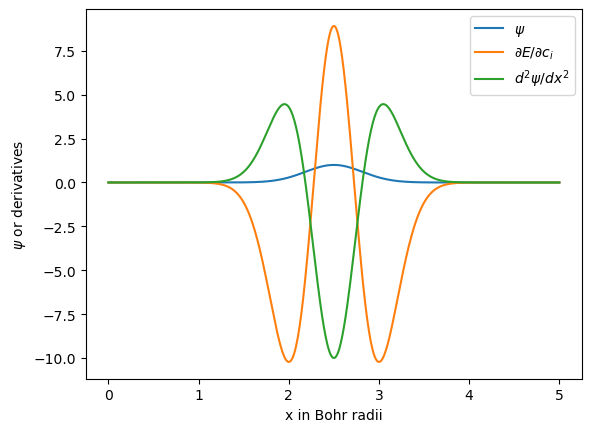

In [8]:
# Let's start with a guess for the wavefunction: a gaussian
psi = np.zeros(N)
# Initialise with gaussian, leave ends exactly zero
psi[1:-1] = np.exp(-5.0*(x_val[1:-1]-L/2)**2)
pot = np.zeros(N) 
print(f"Initial energy is {eval_energy(psi,pot,dx)}")
plt.plot(x_val,psi,label=r'$\psi$')
plt.plot(x_val,dE_dpsi(psi,pot,dx),label=r'$\partial E/\partial c_i$')
plt.plot(x_val,second_derivative_second(psi,dx),label=r'$d^2\psi/dx^2$')
plt.legend()
plt.xlabel('x in Bohr radii')
plt.ylabel(r'$\psi$ or derivatives')

Now we will pass our function and the gradient to the Scipy `optimize.minimize` function, and use conjugate gradients to find the energy minimum.  We will also print the numerical energy for the exact solution, and the exact energy.  Our optimisation process should find an energy *above* the numerical solution.

In [30]:
ret = optimize.minimize(eval_energy,psi,args=(pot,dx),method='CG',jac=dE_dpsi,tol=1e-4,options={'disp':True,'maxiter':10})
# We can add these options to display more information, and impose a maximum number of iterations
# options={'disp':True,'maxiter':5000}
print(f"Method success: {ret.success}")
print(f"Energy is {eval_energy(ret.x,pot,dx)}")
print(f"Iterations {ret.nit}")
print(ret.message)
print(f"Numerical energy is {eval_energy(np.sin(np.pi*x_val/L),pot,dx)}")
print(f"Analytic energy is {0.5*np.pi*np.pi/(L*L)}")

         Current function value: 0.633347
         Iterations: 10
         Function evaluations: 42
         Gradient evaluations: 42
Method success: False
Energy is 0.6333469337144567
Iterations 10
Maximum number of iterations has been exceeded.
Numerical energy is 0.19739143862870512
Analytic energy is 0.19739208802178715


I have added a tolerance (the option `tol=`) to ensure that we don't keep optimising until we encounter numerical noise; the tolerance *seems* to be an upper limit on the RMS magnitude of the gradient.  Let's now check the results against what we know analytically.

Text(0.5, 1.0, 'Comparing exact and optimised wavefunctions')

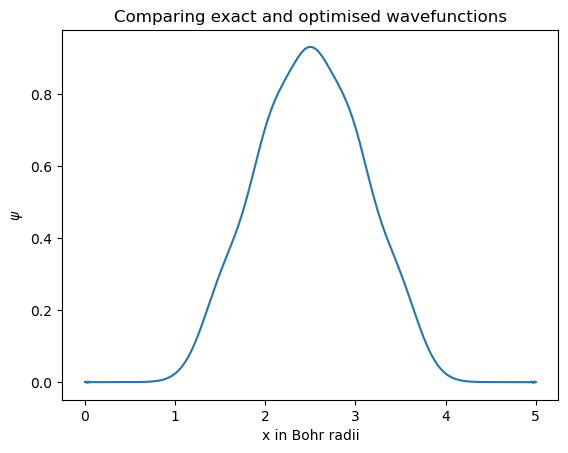

In [32]:
# Normalise and plot analytic answer
#psi_norm_ana = integrate.trapezoid(np.sin(np.pi*x_val/L)*np.sin(np.pi*x_val/L),x_val)
#plt.plot(x_val,np.sin(np.pi*x_val/L)/np.sqrt(psi_norm_ana))

# Normalise and plot numerical answer
psi_norm_num = integrate.trapezoid(ret.x*ret.x,x_val)
plt.plot(x_val,ret.x/np.sqrt(psi_norm_num))
plt.xlabel('x in Bohr radii')
plt.ylabel(r'$\psi$')
plt.title('Comparing exact and optimised wavefunctions')

Text(0.5, 1.0, 'Difference between exact and optimised wavefunctions')

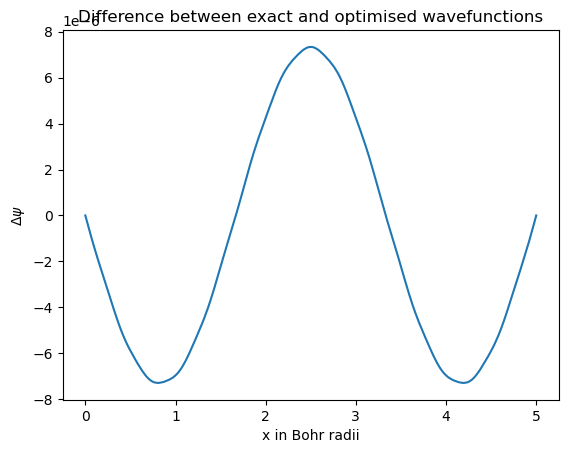

In [28]:
# Now plot difference
plt.plot(x_val,ret.x/np.sqrt(psi_norm_num) - np.sin(np.pi*x_val/L)/np.sqrt(psi_norm_ana))
plt.xlabel('x in Bohr radii')
plt.ylabel(r'$\Delta\psi$')
plt.title('Difference between exact and optimised wavefunctions')

RMS search direction magnitude 3.409707748217285e-05


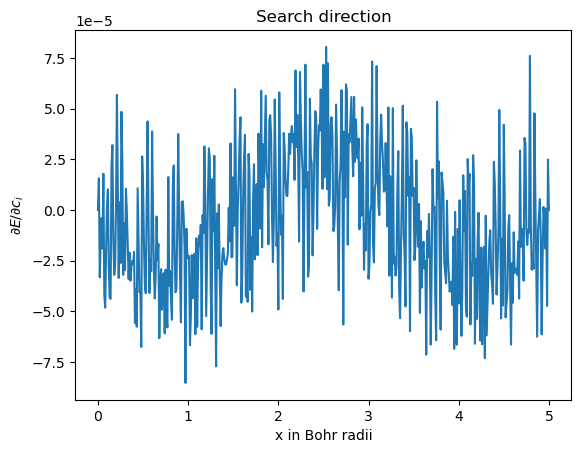

In [29]:
# And check the gradient
plt.plot(x_val,dE_dpsi(ret.x,pot,dx))
plt.xlabel('x in Bohr radii')
plt.ylabel(r'$\partial E/\partial c_i$')
plt.title('Search direction')
print(f"RMS search direction magnitude {np.sqrt(np.dot(dE_dpsi(ret.x,pot,dx),dE_dpsi(ret.x,pot,dx))/N)}")

Note that you could go back and test what happens with other potentials inside the box: you could introduce a barrier, or put a quadratic potential (to mimic the quantum harmonic oscillator), for instance